# Práctica No. 5   Quantum Machine Learning

**Mateo Hoyos Mesa**  
**Sebastián López Dorado**

Computación Cuántica, Facultad de Ingeniería
Universidad de Antioquia, 2025

### 1. Primer Circuito Cuántico en Pennylane

**1.1. Implemente en Pennylane el circuito cuántico explicado en el siguiente video:**   
 
https://www.youtube.com/watch?v=2T8lSejPFog


In [1]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt 

In [77]:
dev = qml.device('default.qubit', wires=2)

In [78]:
@qml.qnode(dev)
def circuit(theta):
    qml.PauliX(wires=1)
    qml.CNOT(wires=[1, 0])
    qml.RY(theta, wires=0)
    
    return qml.expval(qml.PauliZ(wires=0))
print(circuit(np.pi))

1.0


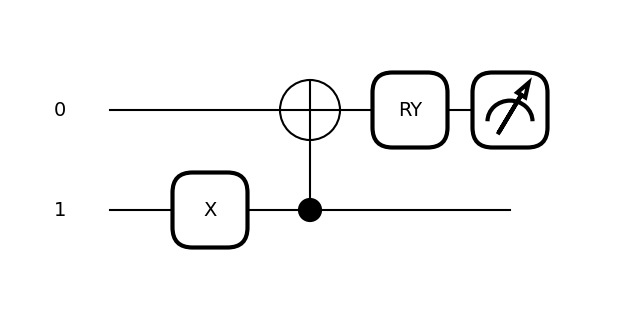

In [5]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit)(np.pi)
plt.show()

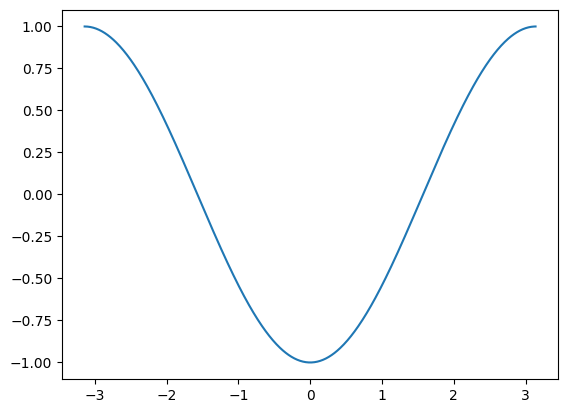

In [6]:
thetas = np.arange(-np.pi, np.pi, 0.01)
measurements = np.zeros(len(thetas))

for i, theta in enumerate(thetas):
    measurements[i] = circuit(theta)
    
plt.plot(thetas,measurements)
plt.show()

**1.2. Ahora implemente en Pennylane el circuito cuántico explicado en el siguiente video, relacionado al proceso de optimizar parámetros de un PQC (Parameterized Quantum Circuit):**

https://www.youtube.com/watch?v=TiQ7T1h8VAQ

In [10]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt 

In [11]:
dev = qml.device('lightning.qubit', wires=1)

@qml.qnode(dev)
def circuit(theta):
    qml.PauliX(wires=0)
    qml.RY(theta, wires=0)
    return qml.expval(qml.PauliZ(0))
circuit(np.pi)

1.0

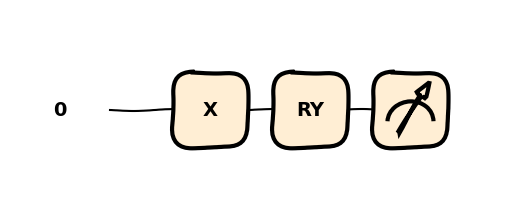

In [18]:
qml.drawer.use_style('sketch')
fig, ax = qml.draw_mpl(circuit)(0.1)
plt.show()

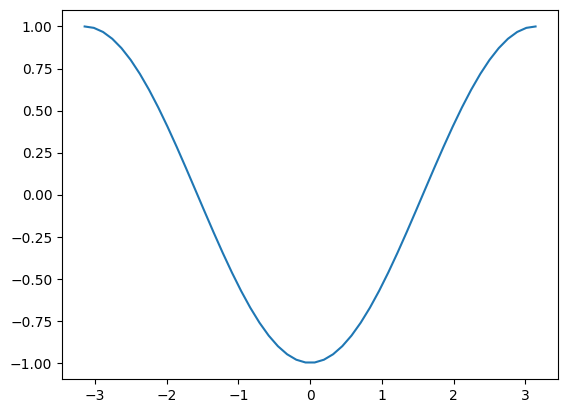

In [30]:
thetas = np.linspace(-np.pi, np.pi, 50)
measurements = []

for theta in thetas:
    measurements.append(circuit(theta))
    
fig,ax=plt.subplots()
ax.plot(thetas,measurements)

In [31]:
theta = np.array([-2.0],requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.1)

In [32]:
n_it = 100
for it in range(n_it):
    theta,prev_cost = opt.step_and_cost(circuit,theta)
    if it%10==0:
        print('Theta: ',theta,'Cost: ',circuit(theta))

Theta:  [-1.90907026] Cost:  [0.33185934]
Theta:  [-0.95268251] Cost:  [-0.579499]
Theta:  [-0.35999832] Cost:  [-0.93589741]
Theta:  [-0.12693105] Cost:  [-0.99195506]
Theta:  [-0.04431925] Cost:  [-0.99901806]
Theta:  [-0.01545577] Cost:  [-0.99988056]
Theta:  [-0.0053892] Cost:  [-0.99998548]
Theta:  [-0.0018791] Cost:  [-0.99999823]
Theta:  [-0.0006552] Cost:  [-0.99999979]
Theta:  [-0.00022846] Cost:  [-0.99999997]


**2.2 Dicho tutorial presenta dos ejemplos diferentes de implementación de circuitos cuánticos variacionales. De estos dos ejemplos, analice e implemente el primero de ellos.**

https://pennylane.ai/qml/demos/tutorial_variational_classifier

Ajuste de la función de paridad

In [40]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [41]:
dev = qml.device("default.qubit")

Nodos cuánticos y clásicos

In [46]:
#Cuántico
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)
        
        
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])
    
    
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [47]:
#Clásico
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

Costo

In [43]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)


def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc


def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

El conjunto de datos de paridad para entrenamiento

In [28]:
data = np.loadtxt("data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


Inicializamos las variables aleatoriamente (pero fijamos una semilla para reproducibilidad).

In [29]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0


Se crea una instancia de optimizador y tamaño de lote

In [30]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

Entrenamiento

In [31]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 2.3147651 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9664866 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.9208589 | Accuracy: 0.5000000
Iter:    4 | Cost: 2.6276126 | Accuracy: 0.5000000
Iter:    5 | Cost: 0.9323119 | Accuracy: 0.6000000
Iter:    6 | Cost: 1.1903549 | Accuracy: 0.5000000
Iter:    7 | Cost: 2.0508989 | Accuracy: 0.4000000
Iter:    8 | Cost: 1.1275531 | Accuracy: 0.6000000
Iter:    9 | Cost: 1.1659803 | Accuracy: 0.6000000
Iter:   10 | Cost: 1.1349618 | Accuracy: 0.6000000
Iter:   11 | Cost: 0.9994063 | Accuracy: 0.6000000
Iter:   12 | Cost: 1.0812559 | Accuracy: 0.6000000
Iter:   13 | Cost: 1.2863155 | Accuracy: 0.6000000
Iter:   14 | Cost: 2.2658259 | Accuracy: 0.4000000
Iter:   15 | Cost: 1.1323724 | Accuracy: 0.6000000
Iter:   16 | Cost: 1.3439737 | Accuracy: 0.8000000
Iter:   17 | Cost: 2.0076168 | Accuracy: 0.6000000
Iter:   18 | Cost: 1.2685760 | Accuracy: 0.5000000
Iter:   19 | Cost: 1.6762475 | Accuracy: 0.5000000
Iter:   20 | Cost: 1.1868237 | 

Circuito implementado

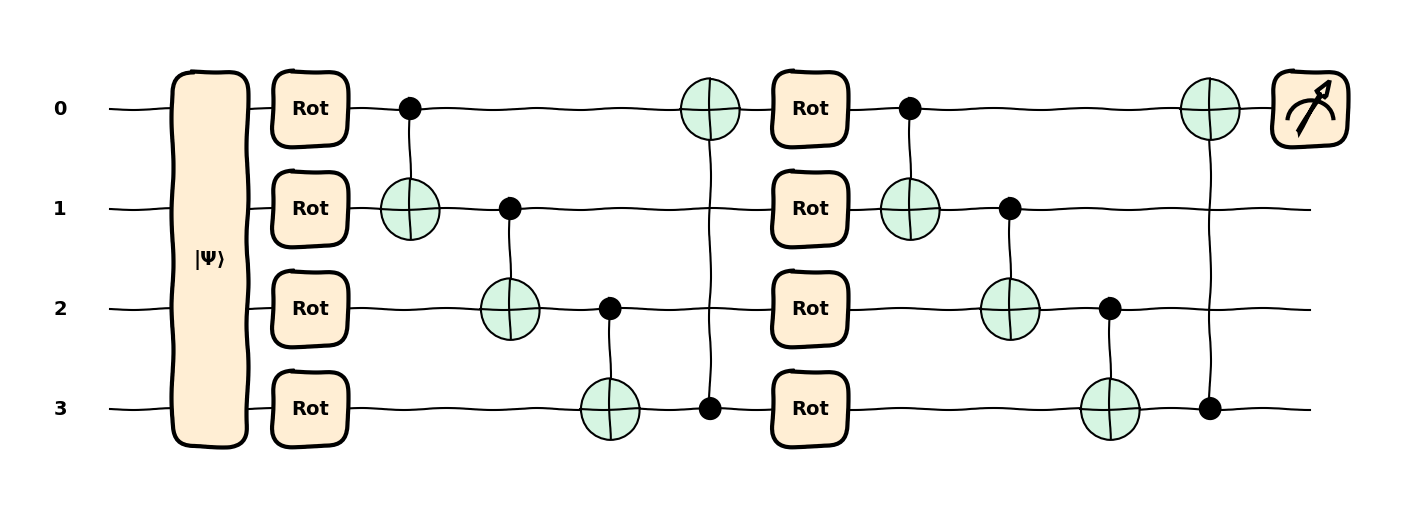

In [39]:
qml.drawer.use_style('sketch')
fig, ax = qml.draw_mpl(circuit)(weights_init, X[2])
plt.show()

Pesos finales resultantes luego del entrenamiento realizado.

In [33]:
print("Weights:", weights)
print("Bias: ", bias)

Weights: [[[ 1.76405235e-02  1.56275530e+00  9.41007496e+00]
  [ 2.24089320e-02  1.73042677e+01 -3.18095132e+00]
  [ 9.50088418e-03  3.15957666e+00 -1.32954606e-01]
  [ 4.10598502e-03  4.72194868e+00  4.52141863e-02]]

 [[ 7.61037725e-03  1.21675016e-03  4.43863233e-03]
  [-9.13257927e-01  2.55275727e-02 -2.05158264e-03]
  [-1.08400003e+01 -1.57068301e+01 -2.55298982e-02]
  [-1.80411655e-02 -2.35109405e+01 -7.42165020e-03]]]
Bias:  0.000838231968105607


Validación

In [34]:
data = np.loadtxt("data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0
